# Yelp Data Challenge - Restaurant Recommender

Lei Chen

Nov 2018

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [2]:
df = pd.read_csv('../data/last_2_years_restaurant_reviews.csv', encoding='ISO-8859-1' )

In [3]:
df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id,address,...,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,avg_stars,state
0,--9e1ONYQuAa-CB_Rrw7Tw,0,2017-02-14,0,VETXTwMw6qxzOVDlXfe6Tg,5,went for dinner tonight. Amazing my husband ha...,0,ymlnR8UeFvB4FZL56tCZsA,3355 Las Vegas Blvd S,...,"{'Monday': '11:30-14:0', 'Tuesday': '11:30-14:...",1.0,36.123183,-115.16919,Delmonico Steakhouse,The Strip,89109.0,1546.0,4.0,NV
1,--9e1ONYQuAa-CB_Rrw7Tw,0,2017-12-04,0,S8-8uZ7fa5YbjnEtaW15ng,5,This was an amazing dinning experience! ORDER ...,0,9pSSL6X6lFpY3FCRLEH3og,3355 Las Vegas Blvd S,...,"{'Monday': '11:30-14:0', 'Tuesday': '11:30-14:...",1.0,36.123183,-115.16919,Delmonico Steakhouse,The Strip,89109.0,1546.0,4.0,NV
2,--9e1ONYQuAa-CB_Rrw7Tw,0,2016-08-22,1,1nK5w0VNfDlnR3bOz13dJQ,5,My husband and I went there for lunch on a Sat...,1,gm8nNoA3uB4In5o_Hxpq3g,3355 Las Vegas Blvd S,...,"{'Monday': '11:30-14:0', 'Tuesday': '11:30-14:...",1.0,36.123183,-115.16919,Delmonico Steakhouse,The Strip,89109.0,1546.0,4.0,NV
3,--9e1ONYQuAa-CB_Rrw7Tw,0,2016-09-13,0,N1Z93BthdJ7FT2p5S22jIA,3,Went for a nice anniversary dinner. Researched...,0,CEtidlXNyQzgJSdF1ubPFw,3355 Las Vegas Blvd S,...,"{'Monday': '11:30-14:0', 'Tuesday': '11:30-14:...",1.0,36.123183,-115.16919,Delmonico Steakhouse,The Strip,89109.0,1546.0,4.0,NV
4,--9e1ONYQuAa-CB_Rrw7Tw,0,2015-02-02,0,_Uwp6FO1X-avE9wqTMC59w,5,This place is first class in every way. Lobste...,0,-Z7Nw2UF7NiBSAzfXNA_XA,3355 Las Vegas Blvd S,...,"{'Monday': '11:30-14:0', 'Tuesday': '11:30-14:...",1.0,36.123183,-115.16919,Delmonico Steakhouse,The Strip,89109.0,1546.0,4.0,NV


## 1. Clean data and get rating data 

#### Select relevant columns in the original dataframe

In [3]:
# Get business_id, user_id, stars for recommender

df_rec = df[['business_id', 'user_id', 'stars']]
df_rec.head()

,business_id,user_id,stars
0,--9e1ONYQuAa-CB_Rrw7Tw,ymlnR8UeFvB4FZL56tCZsA,5
1,--9e1ONYQuAa-CB_Rrw7Tw,9pSSL6X6lFpY3FCRLEH3og,5
2,--9e1ONYQuAa-CB_Rrw7Tw,gm8nNoA3uB4In5o_Hxpq3g,5
3,--9e1ONYQuAa-CB_Rrw7Tw,CEtidlXNyQzgJSdF1ubPFw,3
4,--9e1ONYQuAa-CB_Rrw7Tw,-Z7Nw2UF7NiBSAzfXNA_XA,5


#### There are many users that haven't given many reviews, exclude these users from the item-item similarity recommender

In [5]:
lst = df.set_index('user_id')['business_id'].apply(lambda x: len(x) != 22)
lst.unique()

array([False])

In [6]:
lst = df.set_index('user_id')['text'].apply(lambda x: len(x))
type(lst)

pandas.core.series.Series

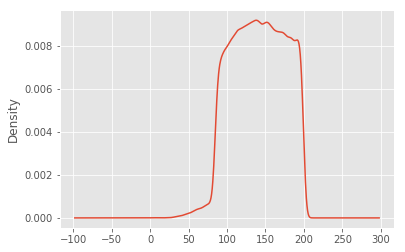

In [7]:
lst[lst < 200].plot.kde()

In [8]:
lst[lst <= 200].sum() / lst.sum()

0.06417221957711304

In [3]:
long_text = df['text'].apply(lambda x: len(x) > 200)

df = df[long_text]
df.shape

(487988, 23)

In [ ]:
recom_csv = '../data/recom.csv'
df_rec.to_csv()

In [5]:
df_rec = pd.read_csv('../data/recom.csv', encoding='ISO-8859-1')
df_rec.head()

,Unnamed: 0,business_id,user_id,stars
0,0,--9e1ONYQuAa-CB_Rrw7Tw,ymlnR8UeFvB4FZL56tCZsA,5
1,2,--9e1ONYQuAa-CB_Rrw7Tw,gm8nNoA3uB4In5o_Hxpq3g,5
2,3,--9e1ONYQuAa-CB_Rrw7Tw,CEtidlXNyQzgJSdF1ubPFw,3
3,5,--9e1ONYQuAa-CB_Rrw7Tw,knB3eczyruOuZaP3TKUKew,5
4,6,--9e1ONYQuAa-CB_Rrw7Tw,9_BhDyzJYf2JwTD9TyXJ4g,5


#### Create utility matrix from records

In [141]:
print(len(df_rec.user_id.values))
len(np.unique(df_rec.user_id.values))

487988


212689

In [147]:
from scipy import sparse
ratings_mat = sparse.lil_matrix((len(np.unique(df_rec.user_id.values)), len(np.unique(df_rec.business_id.values))))

In [153]:
user_list = np.unique(df_rec.user_id.values).tolist()

In [154]:
user_list[:5]

['---1lKK3aKOuomHnwAkAow',
 '---udAKDsn0yQXmzbWQNSw',
 '--0sXNBv6IizZXuV-nl0Aw',
 '--2bpE5vyR-2hAP7sZZ4lA',
 '--2vR0DIsmQ6WfcSzKWigw']

In [157]:
business_list = np.unique(df_rec.business_id.values).tolist()

In [158]:
business_list[:5]

['--9e1ONYQuAa-CB_Rrw7Tw',
 '-1m9o3vGRA8IBPNvNqKLmA',
 '-1vfRrlnNnNJ5boOVghMPA',
 '-3zffZUHoY8bQjGfPSoBKQ',
 '-8R_-EkGpUhBk55K9Dd4mg']

In [159]:
def user_id_to_num(ids):
    num = user_list.index(ids)
    return num

In [163]:
def business_id_to_num(ids):
    num = buiness_list.index(ids)
    return num

In [166]:
for _, row in df_rec.iterrows():
    # subtract 1 from id's due to match 0 indexing
    ratings_mat[user_id_to_num(row.user_id), business_id_to_num(row.business_id)] = row.stars

In [6]:
df_rec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487988 entries, 0 to 487987
Data columns (total 4 columns):
Unnamed: 0     487988 non-null int64
business_id    487988 non-null object
user_id        487988 non-null object
stars          487988 non-null int64
dtypes: int64(2), object(2)
memory usage: 14.9+ MB


In [167]:
df_utility = ratings_mat

In [168]:
df_utility

<212689x5001 sparse matrix of type '<class 'numpy.float64'>'
	with 487988 stored elements in LInked List format>

## 2. Item-Item similarity recommender

### Let's reuse the ItemItemRecommender class derived from previous exercise

Hint: we need to make modification to accommodate the dense numpy array

### Calculate item-item similarity matrix

In [169]:
from sklearn.metrics.pairwise import cosine_similarity
item_sim_mat = cosine_similarity(df_utility.T)

In [170]:
item_sim_mat.shape

(5001, 5001)

### Calculate neighborhood

In [171]:
least_to_most_sim_indexes = np.argsort(item_sim_mat, axis=1)
least_to_most_sim_indexes.shape

(5001, 5001)

In [172]:
# Get neighborhoods
neighborhood_size = 75
neighborhoods = least_to_most_sim_indexes[:, -neighborhood_size:]

In [173]:
neighborhoods.shape

(5001, 75)

### Make rating prediction on a user

In [175]:
user_id = 100

In [176]:
n_users = df_utility.shape[0]
n_items = df_utility.shape[1]

start_time = time()
items_rated_by_this_user = ratings_mat[user_id].nonzero()[1]
# Just initializing so we have somewhere to put rating preds
out = np.zeros(n_items)
for item_to_rate in range(n_items):
    relevant_items = np.intersect1d(neighborhoods[item_to_rate],
                                    items_rated_by_this_user,
                                    assume_unique=True)  # assume_unique speeds up intersection op
    out[item_to_rate] = ratings_mat[user_id, relevant_items] * \
        item_sim_mat[item_to_rate, relevant_items] / \
        item_sim_mat[item_to_rate, relevant_items].sum()


pred_ratings = np.nan_to_num(out)
print(pred_ratings)
print("Execution time: %f seconds" % (time()-start_time))

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


[0. 0. 0. ... 0. 0. 0.]
Execution time: 0.961324 seconds


In [177]:
pred_ratings.shape

(5001,)

In [178]:
# Recommend n restaruant
n = 10

# Get item indexes sorted by predicted rating
item_index_sorted_by_pred_rating = list(np.argsort(pred_ratings))[::-1]

# Find items that have been rated by user
items_rated_by_this_user = df_utility[user_id].nonzero()[1]

# We want to exclude the items that have been rated by user
unrated_items_by_pred_rating = [item for item in item_index_sorted_by_pred_rating
                                if item not in items_rated_by_this_user]

unrated_items_by_pred_rating[:n]

[4136, 1884, 3148, 4928, 4701, 3448, 2709, 4616, 3849, 2068]

In [179]:
for num in unrated_items_by_pred_rating[:n]:
    print(business_list[num])

oJ7mF-fW8GuEoUZ8BSA37Q
N0l-6kdgRXEskiGw3ab05A
bipVXy6DVI0xJaXscBwdXQ
z7IEawyWhsdjc-7clTJWUQ
w7_1xM_WNf8nh2w-tzfAyQ
fdC-5VI6ifj6CR2LjKWRtQ
X7C73DFozvFYiifj0DXhGA
uwBJlA27pNywYTlPBiSqVw
kgw8nBO9ZMRhukfnJd6bxg
PSUOncuqfqHulYj_fusthw
